### Content Based Recommmendation

Recommendations based on the selected songs's features

In [5]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
from scipy import spatial
import operator
import pickle
from scipy.sparse import csr_matrix
from sklearn import preprocessing

### Setting up Spotify API

In [6]:
SPOTIFY_CLIENT_ID = '8bb89c78e01147559a8e3abdcdf84f4e'
SPOTIFY_CLIENT_SECRET = 'fdae390db3e14974bfd77b31b55d67c7'
client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIFY_CLIENT_ID,client_secret=SPOTIFY_CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [7]:
def getTrackFeatures(id):
    meta = sp.track(id)
    features = sp.audio_features(id)

  # meta
    track_id = meta['id']
    name = meta['name']
    album = meta['album']['name']
    artist = meta['album']['artists'][0]['name']
    artist_id =  meta['album']['artists'][0]['id']
    release_date = meta['album']['release_date']
    song_length = meta['duration_ms']
    popularity = meta['popularity']

  # features
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    key=features[0]['key']
    liveness = features[0]['liveness']
    loudness = features[0]['loudness']
    speechiness = features[0]['speechiness']
    tempo = features[0]['tempo']
    time_signature = features[0]['time_signature']
    valence = features[0]['valence']
    mode=features[0]['mode']

    
    track = [track_id,name, album, artist,artist_id,release_date, song_length, popularity, acousticness, danceability,
             energy, instrumentalness, key, liveness, loudness, speechiness, tempo, time_signature,valence, mode]

    return track

In [8]:
# get the recommended songs by Spotify with the searched songs' audio features

track_id ='7tXMHAFEOzcUaUQqovRGho' # the song entered by user
features = getTrackFeatures(track_id)
features = features[6:] # get only the required features
df_song = pd.DataFrame(features).T

Song used : ivy by taylor swift <br>
First, we get random songs from spotify based on the artist Taylor Swift <br>
Taylor swift is versatile artist with songs consisting of different genres, let's see if it can filter it down to the songs similar to ivy.

In [9]:
# get random songs from spotify based on the artist

song_features = getTrackFeatures(track_id)
a=[]
a.append(song_features[4])

recommendations = sp.recommendations(seed_artists=a,limit=100)


### Get features

In [10]:
# add the track features we got from spotify into a list

tracks_features = []

for i in range(len(recommendations['tracks'])):
    track_features = getTrackFeatures(recommendations['tracks'][i]['id'])
    tracks_features.append(track_features)


In [11]:
# the dataframe of the songs we got from spotify 
df_features = pd.DataFrame(tracks_features, columns = ['track_id','name', 'album', 'artist','artist_id', 'release_date', 
                                                           'song_length','popularity', 'acousticness', 'danceability', 'energy', 
                                                           'instrumentalness', 'key', 'liveness', 'loudness', 'speechiness', 
                                                           'tempo', 'time_signature','valence','mode'])
df_features.loc[0] = song_features # the first track in the df is the selected song
df_features['index']= df_features.index

In [12]:
df_features

,track_id,name,album,artist,artist_id,release_date,song_length,popularity,acousticness,danceability,...,instrumentalness,key,liveness,loudness,speechiness,tempo,time_signature,valence,mode,index
0,7tXMHAFEOzcUaUQqovRGho,ivy,evermore,Taylor Swift,06HL4z0CvFAxyc27GXpf02,2020-12-10,260440,72,0.84800,0.329,...,0.000011,2,0.0880,-9.514,0.0397,86.629,4,0.5220,1,0
1,0ZUo4YjG4saFnEJhdWp9Bt,Before He Cheats,Some Hearts,Carrie Underwood,4xFUf1FHVy696Q1JQZMTRj,2005-11-14,199946,76,0.27100,0.519,...,0.000000,6,0.1190,-3.318,0.0405,147.905,4,0.2900,0,1
2,3bDGwl0X3EjQmIyFD1uif5,Roar,PRISM (Deluxe),Katy Perry,6jJ0s89eD6GaHleKKya26X,2013-01-01,223546,1,0.00635,0.560,...,0.000013,7,0.5500,-4.817,0.0415,179.771,4,0.4040,0,2
3,5jlsg7onynIipVy5krMaRZ,Hair (feat. Sean Paul),Hair (feat. Sean Paul),Little Mix,3e7awlrlDSwF3iM0WBjGMp,2016-04-15,233826,21,0.00623,0.712,...,0.000002,7,0.8430,-4.676,0.0487,153.956,4,0.7410,1,3
4,5kofSEc4sxfuss9ukfSw9L,You're Such A,HAIZ,Hailee Steinfeld,5p7f24Rk5HkUZsaS3BLG5F,2016-02-26,216333,0,0.00601,0.619,...,0.000002,11,0.3800,-6.279,0.1720,176.018,4,0.6610,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5TvFfDlVoUWZvfqrhTJzD7,One,x (Deluxe Edition),Ed Sheeran,6eUKZXaKkcviH0Ku9w2n3V,2014-06-21,252760,66,0.87700,0.464,...,0.000000,2,0.0789,-11.120,0.0418,93.528,4,0.3060,1,95
96,0UnhE0UhBTBwtnzEXzP0it,Write On Me,7/27 (Deluxe),Fifth Harmony,1l8Fu6IkuTP0U5QetQJ5Xt,2016-05-27,219560,57,0.35900,0.441,...,0.000002,7,0.1610,-5.427,0.1280,189.879,4,0.4750,0,96
97,2ZyuwVvV6Z3XJaXIFbspeE,Wild Things,Know-It-All (Deluxe),Alessia Cara,2wUjUUtkb5lvLKcGKsKqsR,2015-11-13,188493,64,0.02000,0.741,...,0.000000,1,0.0828,-4.826,0.0886,108.029,4,0.7060,0,97
98,0cITLOYn1Sv4q27zZPqlNK,Red,Red,Taylor Swift,06HL4z0CvFAxyc27GXpf02,2012-10-22,220826,63,0.07730,0.602,...,0.000089,1,0.0910,-4.267,0.0437,124.978,4,0.6410,0,98


###  Similaritiy Measures

In [14]:
# normalize the features
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
features = df_features.drop(columns=['index','track_id','name','artist','album','release_date','artist_id'])
features = min_max_scaler.fit_transform(features)
features = pd.DataFrame(features)

#### Euclidean Distance

In [15]:
from math import*

def euclidean_distance(x,y):
 
    return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

list_euclidean = {}

for i,j in features.iterrows():
    euclidean = euclidean_distance(features.iloc[0], features.iloc[i]) # compare the first song with other songs in the dataset
    list_euclidean[i] = euclidean

sorted_euclidean = sorted(list_euclidean.items(), key=operator.itemgetter(1))[1:]
print("Top 10 recommendations for %s based on Euclidean Distance: " %df_features.iloc[0]['name'] )
for i,j in enumerate(sorted_euclidean):
    if i == 10 : break
    print(df_features.iloc[j[0]]['name']+" by " + df_features.iloc[j[0]]['artist'])

Top 10 recommendations for ivy based on Euclidean Distance: 
One by Ed Sheeran
Afire Love by Ed Sheeran
Supermarket Flowers by Ed Sheeran
Kiss Me by Ed Sheeran
Love Story by Taylor Swift
The Climb by Miley Cyrus
Bubbly by Colbie Caillat
Barcelona by Ed Sheeran
Small Bump by Ed Sheeran
Stay Stay Stay by Taylor Swift


#### Manhattan

In [16]:
list_manhattan = {}

def manhattan_distance(x,y):
 
    return sum(abs(a-b) for a,b in zip(x,y))

for i,j in features.iterrows():
    manhattan = manhattan_distance(features.iloc[0], features.iloc[i])
    list_manhattan[i] = manhattan

sorted_manhattan = sorted(list_manhattan.items(), key=operator.itemgetter(1))[1:]
print("Top 10 recommendations for %s based on Manhattan Distance: " %df_features.iloc[0]['name'] )
for i,j in enumerate(sorted_manhattan):
    if i == 10 : break
    print(df_features.iloc[j[0]]['name']+" by " + df_features.iloc[j[0]]['artist'])

Top 10 recommendations for ivy based on Manhattan Distance: 
One by Ed Sheeran
Supermarket Flowers by Ed Sheeran
Afire Love by Ed Sheeran
The Climb by Miley Cyrus
Kiss Me by Ed Sheeran
Small Bump by Ed Sheeran
Love Story by Taylor Swift
Home To Mama by Justin Bieber
Bloodstream by Ed Sheeran
Hey Stephen by Taylor Swift


In [17]:
from decimal import Decimal

list_minkowski ={}

def nth_root(value, n_root):
 
    root_value = 1/float(n_root)
    return  (Decimal(value) ** Decimal(root_value))
 
def minkowski_distance(x,y,p_value):
 
    return nth_root(sum(pow(abs(a-b),p_value) for a,b in zip(x, y)),p_value)

for i,j in features.iterrows():
    minkowski = minkowski_distance(features.iloc[0], features.iloc[i],2)
    list_minkowski[i] = minkowski
    
sorted_minkowski = sorted(list_minkowski.items(), key=operator.itemgetter(1))[1:]
print("Top 10 recommendations for %s based on Minkowski Distance: " %df_features.iloc[0]['name'] )
for i,j in enumerate(sorted_minkowski):
    if i == 10 : break
    print(df_features.iloc[j[0]]['name']+" by " + df_features.iloc[j[0]]['artist'])

Top 10 recommendations for ivy based on Minkowski Distance: 
One by Ed Sheeran
Afire Love by Ed Sheeran
Supermarket Flowers by Ed Sheeran
Kiss Me by Ed Sheeran
Love Story by Taylor Swift
The Climb by Miley Cyrus
Bubbly by Colbie Caillat
Barcelona by Ed Sheeran
Small Bump by Ed Sheeran
Stay Stay Stay by Taylor Swift


In [18]:
list_jaccard = {}

def jaccard_similarity(x,y):
 
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

for i,j in features.iterrows():
    jaccard = jaccard_similarity(features.iloc[0], features.iloc[i])
    list_jaccard[i] = jaccard
    
sorted_jaccard = reversed(sorted(list_jaccard.items(), key=operator.itemgetter(1))[:-1])
print("Top 10 recommendations for %s based on Jaccard Similarity: " %df_features.iloc[0]['name'] )
for i,j in enumerate(sorted_jaccard):
    if i == 10 : break
    print(df_features.iloc[j[0]]['name']+" by " + df_features.iloc[j[0]]['artist'])

Top 10 recommendations for ivy based on Jaccard Similarity: 
Love Story by Taylor Swift
Kiss Me by Ed Sheeran
Cold As You by Taylor Swift
Mary's Song (Oh My My) by Taylor Swift
One by Ed Sheeran
Home To Mama by Justin Bieber
That's My Girl by Fifth Harmony
Touch It by Ariana Grande
Baby by Justin Bieber
As Long As You Love Me by Justin Bieber


In [19]:
%%time
list_cosine = {}

def square_rooted(x):
 
    return (sqrt(sum([a*a for a in x])))
 
def cosine_similarity_1(x,y):
 
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = square_rooted(x)*square_rooted(y)
    return (numerator/float(denominator))

for i,j in features.iterrows():
    cosine = cosine_similarity_1(features.iloc[0], features.iloc[i])
    list_cosine[i] = cosine
    
sorted_cosine = reversed(sorted(list_cosine.items(), key=operator.itemgetter(1))[:-1])
print("Top 10 recommendations for %s based on Cosine Similarity: " %df_features.iloc[0]['name'] )
for i,j in enumerate(sorted_cosine):
    if i == 10 : break
    print(df_features.iloc[j[0]]['name']+" by " + df_features.iloc[j[0]]['artist'])

Top 10 recommendations for ivy based on Cosine Similarity: 
One by Ed Sheeran
Afire Love by Ed Sheeran
Supermarket Flowers by Ed Sheeran
Kiss Me by Ed Sheeran
Love Story by Taylor Swift
Barcelona by Ed Sheeran
Small Bump by Ed Sheeran
Bubbly by Colbie Caillat
The Climb by Miley Cyrus
Stay Stay Stay by Taylor Swift
Wall time: 38.9 ms


### K-means clustering
Recommend based on similar cluster

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Use silhouette score to find optimal number of clusters to segment the data
num_clusters = np.arange(2,10)
results = {}
for size in num_clusters:
    model = KMeans(n_clusters = size).fit(features)
    predictions = model.predict(features)
    results[size] = silhouette_score(features, predictions)

best_size = max(results, key=results.get)
best_size

2

In [21]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=best_size)
y_kmeans = kmeans.fit_predict(features)

In [22]:
# PCA to reduce our data to 2 dimensions for visualisation
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features)

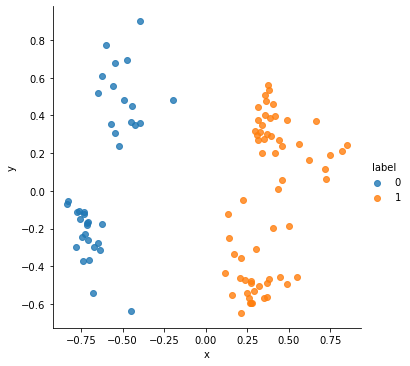

In [23]:
import seaborn as sns

pc = pd.DataFrame(principal_components)
pc['label'] = y_kmeans
pc.columns = ['x', 'y','label']

#plot data with seaborn
cluster = sns.lmplot(data=pc, x='x', y='y', hue='label', 
                   fit_reg=False, legend=True, legend_out=True)

In [24]:
features['label'] = y_kmeans
features.iloc[0]['label'] # the cluster that the song is in 

1.0

In [25]:
# get the songs with the same cluster as first song
df_cluster = features[features['label']==features.iloc[0]['label']]
df_cluster.drop(columns=['label'],inplace=True)
df_cluster 

C:\Users\bebbi\anaconda3\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.639372,0.837209,0.893550,0.063063,0.478326,0.000366,0.181818,0.077243,0.521194,0.036759,0.157358,1.0,0.520009,1.0
3,0.461107,0.244186,0.006359,0.638138,0.908819,0.000055,0.636364,1.000000,0.873562,0.058525,0.647751,1.0,0.777021,1.0
4,0.343937,0.000000,0.006127,0.498498,0.698057,0.000068,1.000000,0.434124,0.756810,0.356711,0.808445,1.0,0.683136,1.0
5,0.632493,0.779070,0.725971,0.785285,0.312407,0.004983,0.909091,0.104131,0.290386,0.114148,0.400227,1.0,0.430818,1.0
6,0.466700,0.000000,0.015286,0.484985,0.724963,0.000370,0.818182,0.072721,0.645448,0.128416,0.465402,1.0,0.239526,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,0.332148,0.779070,0.059025,0.611111,0.992526,0.000000,0.818182,0.655341,1.000000,0.170254,0.239737,1.0,0.568126,1.0
90,0.470753,0.837209,0.178965,0.496997,0.768311,0.000000,0.181818,0.070154,0.926438,0.015719,0.393024,1.0,0.254782,1.0
92,0.157440,0.744186,0.137861,0.692192,0.597907,0.000000,0.636364,0.073821,0.775018,0.095284,0.407438,1.0,0.522357,1.0
93,0.465756,0.872093,0.066719,0.073574,0.560538,0.000000,0.363636,0.142019,0.751347,0.019347,0.699130,1.0,0.258303,1.0


In [26]:
m = csr_matrix(df_cluster.values)
c = cosine_similarity(m[0],m)

In [27]:
sorted_cluster = {}
similar_indices = c[0].argsort()[:-10:-1]
similar_items = [(c[0][i], df_features['index'][i]) for i in similar_indices]
sorted_cluster[0] = similar_items[1:]

In [31]:
def item(id):
    return df_features.loc[df_features['index'] == id]['name'].tolist()[0] #return the song name
def recommend(item_id, num):
    print("Recommending " + str(num) + " songs similar to " + item(item_id) + " based on K-means...")
    print("-------")
    recs = sorted_cluster[item_id][:num]
    for rec in recs:
        print("Recommended: " + item(rec[1]) + " (score:" + str(rec[0]) + ")")
recommend(item_id=0, num=10)

Recommending 10 songs similar to ivy based on K-means...
-------
Recommended: As Long As You Love Me (score:0.9745488347393314)
Recommended: Down (score:0.9389686808376966)
Recommended: No Promises (score:0.9284695917611386)
Recommended: Mary's Song (Oh My My) (score:0.8987241790793974)
Recommended: Treat You Better (score:0.885988161922936)
Recommended: The One That Got Away (score:0.8846143797743993)
Recommended: Hair (feat. Sean Paul) (score:0.8822285681591473)
Recommended: Clean (score:0.8802012632928429)
